## Define the simulation variables for the datasets

In [2]:
import pandas as pd
import numpy as np
from numpy import pi, log10
from numpy.random import default_rng, random, choice
import matplotlib.pyplot as plt

In [3]:
# Parameters cell for Papermill

df_iter = 6
save_file = False

In [4]:
root_dir = '/Users/stevemead/LISAandNEA'
classes = ['glitch', 'nea', 'gwburst']
instances_per_class = 1000
total_instances = len(classes)*instances_per_class
all_sc = ['1', '2', '3']
all_inj_points = ['tm_12', 'tm_23', 'tm_31', 'tm_13', 'tm_32', 'tm_21']

rng = default_rng() # specify the seed for reproducible results

# a pandas dataframe is used to store the variables used to create each instance in the dataset
df = pd.DataFrame()

### Define the datasets

1. Rectangles: fixed amplitude, duration and skyloc
2. Amplitudes and duration from normal distributions
3. GW bursts uniformly and randomly distributed across the sky
4. With laser noise
5. Glitches as shapelets, NEA encounter with fixed M, V and D from incident angles uniformly and randomly distributed, GW bursts as gaussian pulses
6. NEA encounters with various M, V and D
7. With laser noise
8. Selected values of V (10, 20, 40 km s-1) - was not used in the final report

In [5]:
# Dataset 1 and all others
df['type'] = df['type'] = [x for x in classes for y in range(instances_per_class)]
df['t_random'] = (rng.random(size=total_instances)-0.5)*20. # [s] range from -10 to +10 s
df.loc[df.type == 'glitch', 'glitch_type'] = 'RectangleGlitch'
df.loc[df.type == 'nea', 'glitch_type'] = 'RectangleGlitch'
df['glitch_inj_point'] = rng.choice(all_inj_points, total_instances)
df['glitch_width'] = 20. # [s]
df['glitch_level'] = 1.e-11 # [m s-1]
df.loc[df.type == 'glitch', 'glitch_beta'] = 1.
df.loc[df.type == 'nea', 'nea_model'] = rng.choice(['pair_of_glitches_1', 'pair_of_glitches_2'], instances_per_class) # pair_of_glitches_1 pair_of_glitches_2 nea
df['nea_glitch_ratio'] = 1/3 
df['nea_sc'] = rng.choice(all_sc, total_instances)
df['nea_M'] = 1.e9 # [kg]
df['nea_D'] = 1.e5 # [m]
df['nea_V'] = 4e4 # [m s-1]
df['nea_angle_X'] = 0. # [deg] 
df['nea_angle_Y'] = 0. # [deg] 
df['nea_angle_Z'] = 0. # [deg] 
df.loc[df.type == 'gwburst', 'gw_model'] = 'rectangle' # rectangle gaussian
df['gw_width'] = 20. # [s]
df['gw_level'] = 3.e-20 # [dimensionless strain]
df['gw_sigma'] = 1.
df['gw_beta'] = 0. # [rad]
df['gw_lambda'] = 0. # [rad]
df['noise'] = 'none'

# Datasets 2+ (not dataset 1)
if df_iter in [2,3,4,5,6,7,8]:
    # modify only the columns that changed from the previous dataset iteration
    df['glitch_width'] = rng.normal(loc=2., scale=0.33, size=total_instances)
    df['glitch_level'] = rng.normal(loc=1.e-11, scale=0.11e-11, size=total_instances)
    df['nea_glitch_ratio'] = rng.uniform(low=0.1, high=1.0, size=total_instances)
    df['gw_width'] = rng.normal(loc=2., scale=0.33, size=total_instances)
    df['gw_level'] = rng.normal(loc=3.e-20, scale=0.33e-20, size=total_instances)
      # gw_beta constant
      # gw_lambda constant

# Datasets 3+ (not datasets 1 or 2)
if df_iter in [3,4,5,6,7,8]:
    df['gw_beta'] = rng.uniform(low=-pi/2, high=pi/2, size=total_instances) # [rad] ecliptic latitude of gravitational-wave source 
    df['gw_lambda'] = rng.uniform(low=-pi, high=pi, size=total_instances) # [rad] ecliptic longitude of gravitational-wave source 

# Dataset 4 has noise turned on
if df_iter in [4]:
    df['noise'] = 'clock'

# Datasets 5+ (not datasets 1 - 4)
if df_iter in [5,6,7,8]:
    # Glitches use a shapelet with damping time (beta)
    df.loc[df.type == 'glitch', 'glitch_type'] = 'IntegratedShapeletGlitch'
    df.loc[df.type == 'glitch', 'glitch_beta'] = rng.uniform(0.01, 10, instances_per_class)
    # NEA use the physical model, fixed M,V & D, random uniformly distributed orientation
    df.loc[df.type == 'nea', 'nea_model'] = 'nea' # pair_of_glitches_1 pair_of_glitches_2 nea
    df['nea_angle_X'] = rng.uniform(low=-180, high=180, size=total_instances) # [deg]
    df['nea_angle_Y'] = rng.uniform(low=-90, high=90, size=total_instances) # [deg]
    df['nea_angle_Z'] = rng.uniform(low=-180, high=180, size=total_instances) # [deg]
    # GW bursts use a gaussian shape
    df.loc[df.type == 'gwburst', 'gw_model'] = 'gaussian' # rectangle gaussian
    df['gw_sigma'] = rng.uniform(low=0.01, high=10., size=total_instances)

# Datasets 6+ (not datasets 1 - 5)
if df_iter in [6,7,8]:
    # Vary the NEAs' mass, relative velocity and impact parameter
    # df['nea_M'] = rng.uniform(low=1e6, high=1e9, size=total_instances) # [kg]
    df['nea_M'] = 10**rng.uniform(low=6, high=9, size=total_instances) # [kg] NOT A UNIFORM DISTRIBUTION!
    df['nea_V'] = rng.uniform(low=1e4, high=4e4, size=total_instances) # [m s-1]
    df['nea_D'] = rng.uniform(low=1e4, high=1e5, size=total_instances) # [m]

# Datasets 7 and 8 have noise turned on
if df_iter in [7,8]:
    df['noise'] = 'clock'

# Dataset 8 only
if df_iter in [8]:
    # Selected values of the NEA's relative velocity
    df['nea_V'] = rng.choice([1e4,2e4,4e4], size=total_instances) # [m s-1]

df['nea_tau'] = df['nea_D']/df['nea_V']
df['nea_MoverDV'] = df['nea_M']/(df['nea_D']*df['nea_V'])

# Shuffle the order of all instances in the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df_path = f'{root_dir}/datasets/df{df_iter}.txt'
if save_file:
    df.to_csv(df_path, index=False)

In [7]:
def mass(d):
    return log10(4/3*pi*(d/2)**3 * 2600)

mass(10),mass(100),mass(1000),mass(10000)

(6.1339719702813085, 9.133971970281308, 12.133971970281308, 15.133971970281308)

In [162]:
def plot_histogram_of(series, title='', bins=20, xlabel='label me', ylabel='Frequency'):
    fig = plt.subplot()
    plt.hist(series,bins)
    fig.set(title=title, ylabel=ylabel, xlabel=xlabel,)
    plt.show()

def plot_logx_histogram_of(series, title='', bins=20, xlabel='label me', ylabel='Frequency'):
    fig = plt.subplot()
    logbins = np.geomspace(series.min(), series.max(), bins+1)
    plt.hist(series,logbins)
    fig.set(title=title, ylabel=ylabel, xlabel=xlabel,)
    plt.xscale('log')
    plt.show()


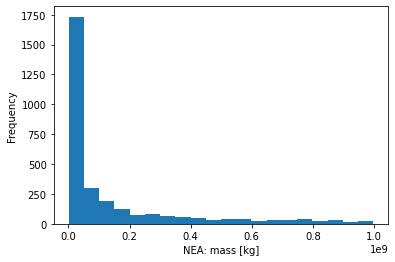

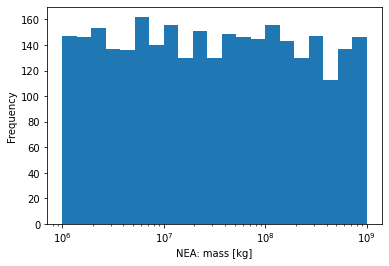

In [163]:
plot_histogram_of(df['nea_M'], xlabel='NEA: mass [kg]')
plot_logx_histogram_of(df['nea_M'], xlabel='NEA: mass [kg]', bins=21)

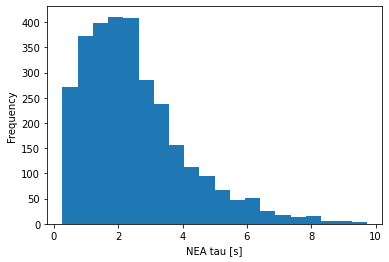

In [164]:
plot_histogram_of(df['nea_tau'], xlabel='NEA tau [s]')

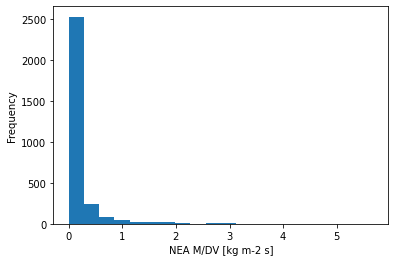

In [165]:
plot_histogram_of(df['nea_MoverDV'], xlabel='NEA M/DV [kg m-2 s]')

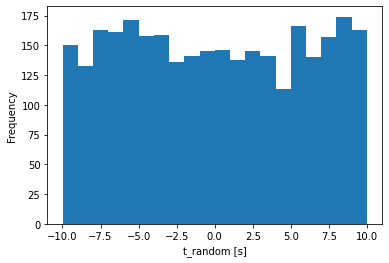

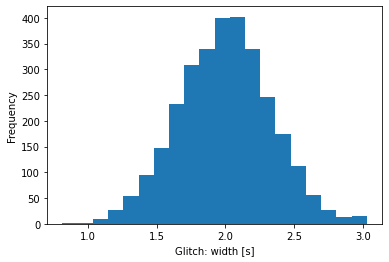

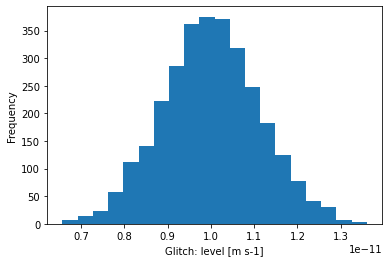

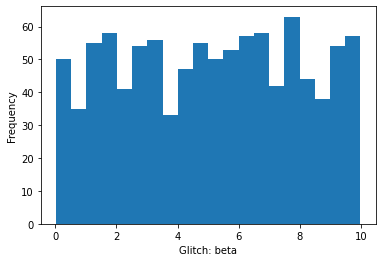

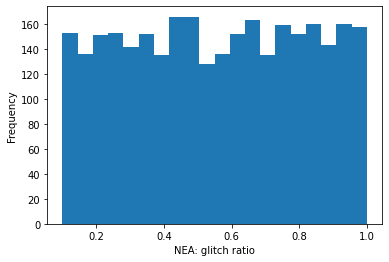

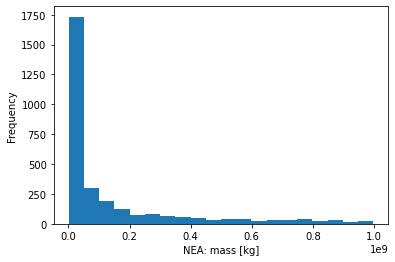

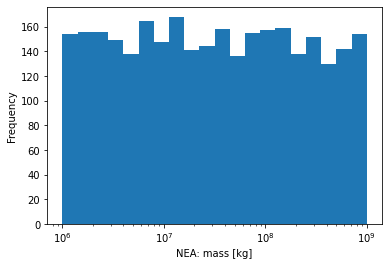

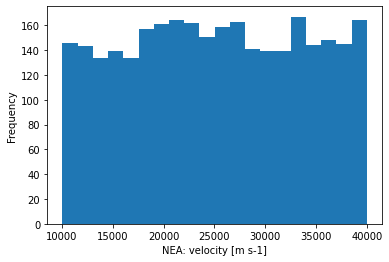

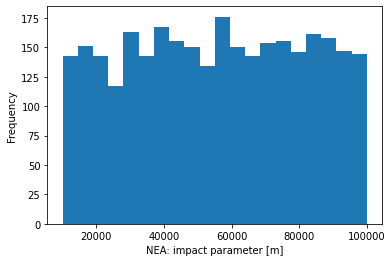

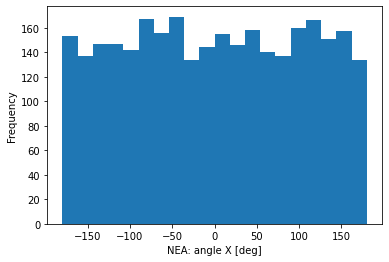

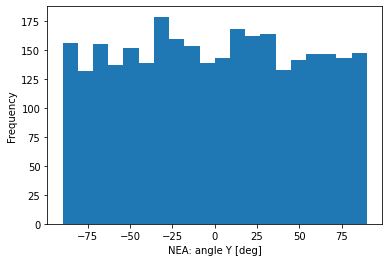

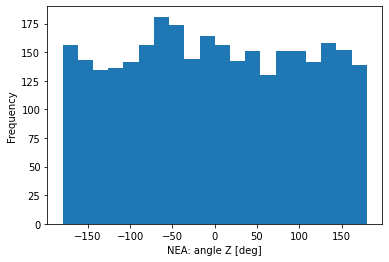

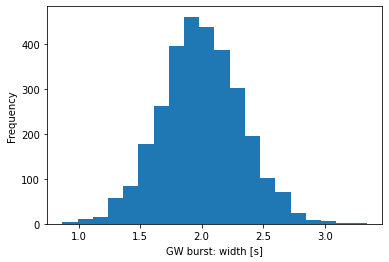

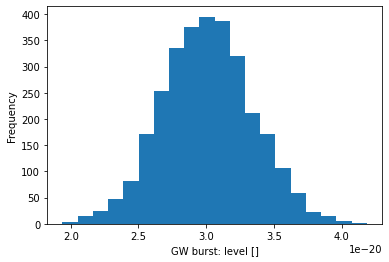

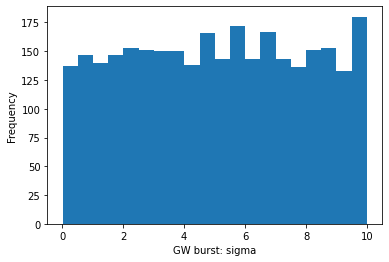

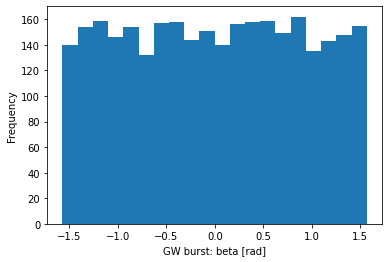

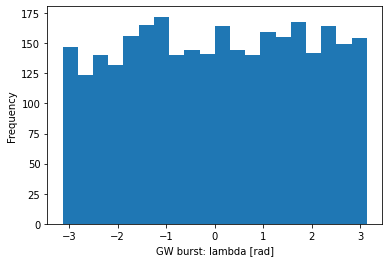

In [166]:
plot_histogram_of(df['t_random'], xlabel='t_random [s]')
plot_histogram_of(df['glitch_width'], xlabel='Glitch: width [s]')
plot_histogram_of(df['glitch_level'], xlabel='Glitch: level [m s-1]')
plot_histogram_of(df['glitch_beta'], xlabel='Glitch: beta')
plot_histogram_of(df['nea_glitch_ratio'], xlabel='NEA: glitch ratio')
plot_histogram_of(df['nea_M'], xlabel='NEA: mass [kg]')
plot_logx_histogram_of(df['nea_M'], xlabel='NEA: mass [kg]')
plot_histogram_of(df['nea_V'], xlabel='NEA: velocity [m s-1]')
plot_histogram_of(df['nea_D'], xlabel='NEA: impact parameter [m]')
plot_histogram_of(df['nea_angle_X'], xlabel='NEA: angle X [deg]')
plot_histogram_of(df['nea_angle_Y'], xlabel='NEA: angle Y [deg]')
plot_histogram_of(df['nea_angle_Z'], xlabel='NEA: angle Z [deg]')
plot_histogram_of(df['gw_width'], xlabel='GW burst: width [s]')
plot_histogram_of(df['gw_level'], xlabel='GW burst: level []')
plot_histogram_of(df['gw_sigma'], xlabel='GW burst: sigma')
plot_histogram_of(df['gw_beta'], xlabel='GW burst: beta [rad]')
plot_histogram_of(df['gw_lambda'], xlabel='GW burst: lambda [rad]')

In [167]:
df[['nea_M','nea_D','nea_V','nea_tau']].head(20)

,nea_M,nea_D,nea_V,nea_tau
0,7.319487e+08,17163.268294,32234.123643,0.532456
1,2.763013e+08,86488.102720,25012.550866,3.457788
2,1.420354e+06,11321.376205,13724.310077,0.824914
3,3.282540e+06,78804.432246,25414.924355,3.100715
4,8.281421e+07,59254.730827,16780.239033,3.531221
5,7.945170e+08,23164.184386,21052.757308,1.100292
6,2.386875e+08,73625.608319,39876.321168,1.846349
7,2.808518e+07,84037.440588,26118.176363,3.217585
8,1.543667e+07,59233.004110,24913.766289,2.377521
9,1.972496e+07,66585.247347,17991.568710,3.700914
